In [1]:
import cudf
import cupy
import glob
import xarray
import scipy.io as sio
import datashader as ds
import numpy as np
from collections import OrderedDict
import datashader.transfer_functions as tf
import pandas as pd
import matplotlib.pyplot as plt
from cupyx.scipy.special import kl_div
import seaborn as sns
from matplotlib.colors import LogNorm

In [2]:
data = sio.loadmat('pavia.mat')
gt = sio.loadmat('pavia_gt.mat')
mask = sio.loadmat('PaviaGrTruthMask.mat')
wvs = sio.loadmat('PaviaWavelengths.mat')
hsi = data['paviaU']
gt = gt['paviaU_gt']
mask = mask['PaviaGrTruthMask']
wvs = wvs['PaviaWavelengths']
wvs = cupy.squeeze(np.round(wvs,3),axis=0)*1000

In [165]:
hsi_vec = cupy.reshape(hsi,(hsi.shape[0]*hsi.shape[1],hsi.shape[2]))
mask_vec = cupy.reshape(mask,(mask.shape[0]*mask.shape[1],)).astype(bool)
hsi_vec = hsi_vec/cupy.max(hsi_vec)
hsi_vec[hsi_vec==0]=0.0001
hsi_vec = cupy.array(hsi_vec)
RGB_vec = hsi_vec[:,[56,28,9]]
RGB = cupy.reshape(RGB_vec,(hsi.shape[0],hsi.shape[1],3))

In [37]:
time = cupy.linspace(0,1,hsi_vec.shape[1])
cdf = cudf.DataFrame(hsi_vec,columns=wvs)
data_df = pd.DataFrame(hsi_vec.get(),columns=wvs)
cdf.head()

430.0     434.0     438.0     443.0     447.0     451.0     455.0  \
0  0.080875  0.062375  0.058000  0.046375  0.036375  0.039875  0.045625   
1  0.075500  0.068250  0.065875  0.056875  0.047250  0.047125  0.042000   
2  0.077625  0.093250  0.069500  0.045000  0.035625  0.037500  0.034250   
3  0.079625  0.074000  0.060250  0.069500  0.063500  0.035500  0.022250   
4  0.078125  0.070000  0.060000  0.045000  0.047125  0.042625  0.033000   

     460.0     464.0     468.0  ...     822.0     826.0     830.0     835.0  \
0  0.04025  0.037000  0.038125  ...  0.427500  0.427000  0.416875  0.407000   
1  0.03925  0.040500  0.041125  ...  0.325625  0.322875  0.317250  0.313625   
2  0.03450  0.041500  0.039875  ...  0.285250  0.286000  0.280250  0.274125   
3  0.02475  0.024125  0.028000  ...  0.335500  0.334375  0.326125  0.317625   
4  0.02600  0.028875  0.033250  ...  0.302875  0.299000  0.293000  0.286125   

      839.0     843.0     847.0     852.0     856.0     860.0  
0  0.403250  0.400625  0.401250  0.402625  0.404750  0.406250  
1  0.313875  0.312625  0.308500  0.305250  0.308000  0.316000  
2  0.275250  0.278125  0.283250  0.288500  0.293125  0.295125  
3  0.318875  0.321375  0.321125  0.321625  0.327500  0.330500  
4  0.291000  0.301875  0.303000  0.298250  0.303875  0.307000  

[5 rows x 103 columns]

In [5]:
sim_mat = cupy.zeros((hsi_vec.shape[1],hsi_vec.shape[1]))
for i in range(0,sim_mat.shape[0]):
    v1 = hsi_vec[:,i]
    for j in range(0,sim_mat.shape[1]):
        v2 = hsi_vec[:,j]
        sim_mat[i,j] = .5*cupy.sum(kl_div(v1,v2))+.5*cupy.sum(kl_div(v2,v1))+0.001

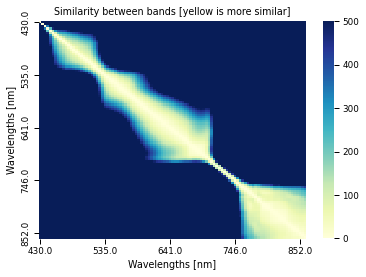

In [250]:
df = pd.DataFrame(sim_mat.get(),columns=wvs,index=wvs)
sns.set_context("paper")
p = sns.heatmap(df, cmap="YlGnBu", xticklabels=25, yticklabels=25, vmin=0, vmax=500)
p.set_xlabel("Wavelengths [nm]")
p.set_ylabel("Wavelengths [nm]")
p.set(title="Similarity between bands [yellow is more similar]");

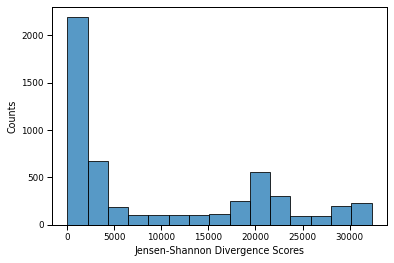

In [251]:
p = sns.histplot(data=np.triu(sim_mat.get()),x=np.unique(sim_mat.get()))
p.set_xlabel("Jensen-Shannon Divergence Scores")
p.set_ylabel("Counts");

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
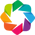

:RGB   [x,y]   (R,G,B,A)

In [94]:
import holoviews as hv
import holoviews.operation.datashader as hd
from matplotlib import cm
hd.shade.cmap=cm.hsv
hv.extension("bokeh","matplotlib")
hv.output(backend="bokeh")
xticks = [(p/100,df.columns.values[p]) for p in range(len(df.columns.values))]
yticks = [(p/10,p*10) for p in range(11)]
cvs = ds.Canvas()
agg = cvs.line(data_df, x=time.get(), y=list(df.columns.values), agg=ds.count(),axis=1)
hd.shade(hv.Image(agg)).opts(height=500, width=1000,xlabel="Wavelength [nm]",ylabel="Reflectance [%]",xticks=xticks[::10],yticks=yticks)

In [132]:
from cuml import KMeans
from cuml.cluster import KMeans

kmeans_float = KMeans(n_clusters=10)
kmeans_float.fit(cdf)
C = kmeans_float.cluster_centers_.to_pandas()
L = kmeans_float.labels_.to_pandas()
L_ = L.values
L_ = cupy.reshape(L_,(hsi.shape[0],hsi.shape[1]))

<AxesSubplot:>

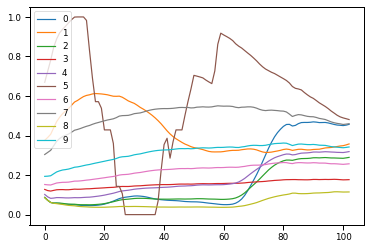

In [254]:
C.transpose().plot()

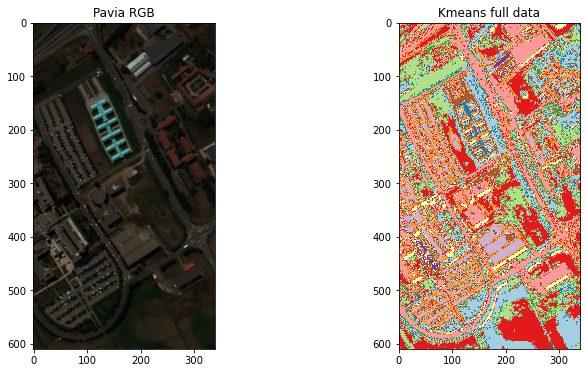

In [195]:
fig, (ax0,ax1) = plt.subplots(nrows=1,ncols=2,sharex=True,figsize=(12,6))
ax0.set_title('Pavia RGB')
ax0.imshow(RGB.get())
ax1.set_title('KMeans full data')
pcm = ax1.imshow(L_,cmap=cm.Paired)

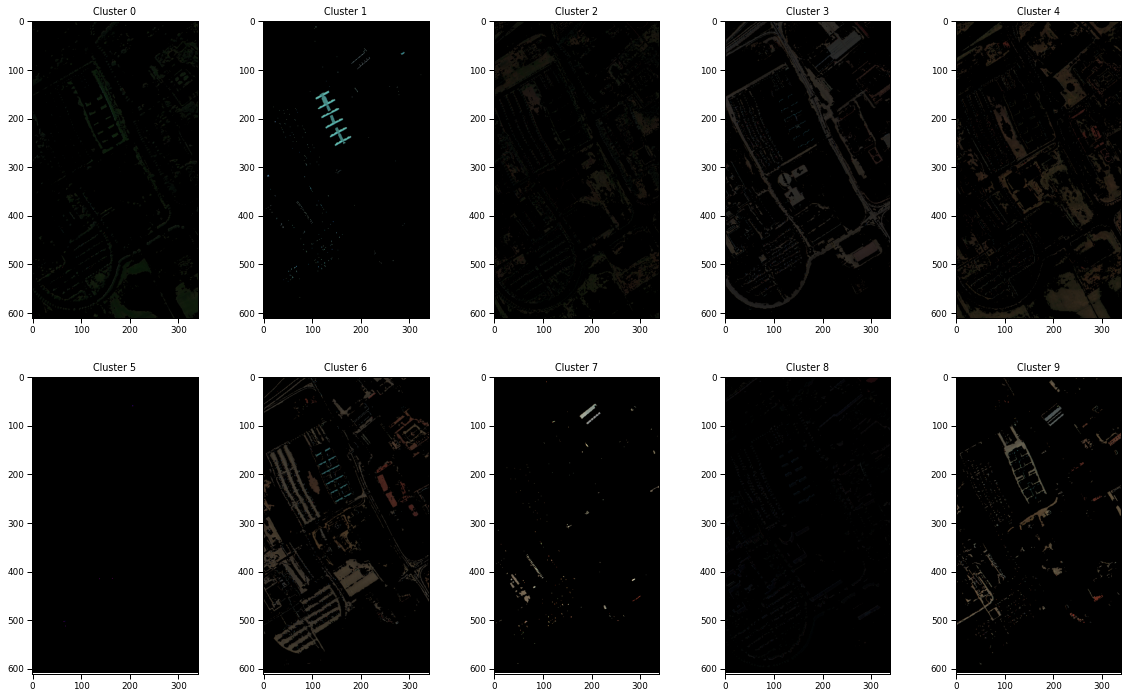

In [257]:
fig,axs = plt.subplots(2,5,figsize=(20,12))
for n in range(10):
    ax = plt.subplot(2,5,n+1)
    rr, cc = np.where(L_==n)
    L_temp = np.zeros((RGB.shape))
    L_temp[rr,cc] = RGB[rr,cc,:].get()
    plt.imshow(L_temp)
    ax.set_title(f"Cluster {n}")
    ax.set_xlabel("")

In [270]:
from cuml import UMAP
UMAP_float = UMAP(n_components = 2)
UMAP_float.fit(cdf)
gt_vec = np.reshape(gt,(gt.shape[0],gt.shape[1]))
UMAP_pts = UMAP_float.embedding_.to_pandas()

UMAP()

<AxesSubplot:xlabel='0', ylabel='1'>

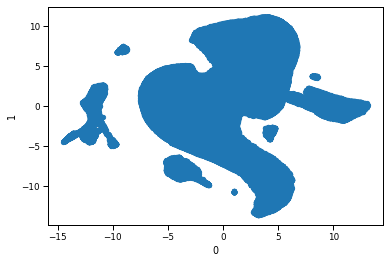

In [286]:
UMAP_pts.plot.scatter(x=0,y=1)